# Binary Classifier for TP53 Mutation Prediction
This notebook aims to predict mutations in the TP53 protein and identify genes responsible for these mutations.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import IsolationForest
from xgboost import XGBClassifier


### Dataset Loading and Preprocessing

In [2]:
# Load datasets
mutations = pd.read_csv('data/OmicsSomaticMutations.csv')
expression = pd.read_csv('data/OmicsExpressionProteinCodingGenesTPMLogp1.csv')


# Filter mutations for TP53
mutations = mutations[mutations['HugoSymbol'] == 'TP53']

# Rename the first column of expression to 'ModelID'
expression.rename(columns={expression.columns[0]: 'ModelID'}, inplace=True)

# Merge datasets
merged = pd.merge(expression, mutations[['ModelID', 'HugoSymbol']], on='ModelID', how='left')

# Create a boolean column 'Mutated'
merged['Mutated'] = np.where(merged['HugoSymbol'].isnull(), 0, 1)

C:\Users\tommy\AppData\Local\Temp\ipykernel_15516\2312616048.py:2: DtypeWarning: Columns (22,50,56,57,58,59,61) have mixed types. Specify dtype option on import or set low_memory=False.
  mutations = pd.read_csv('data/OmicsSomaticMutations.csv')


### Exploratory Data Analysis (EDA)

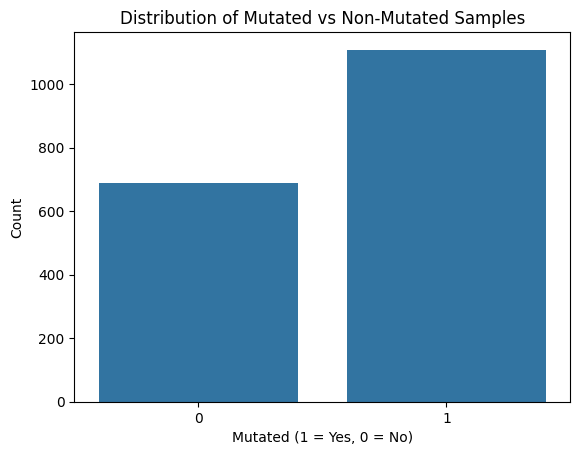

In [3]:
# Visualize the distribution of the 'Mutated' column
sns.countplot(data=merged, x='Mutated')
plt.title('Distribution of Mutated vs Non-Mutated Samples')
plt.xlabel('Mutated (1 = Yes, 0 = No)')
plt.ylabel('Count')
plt.show()

### Outlier detection

In [4]:
merged_mod= merged.drop(columns=['ModelID', 'HugoSymbol', 'Mutated'])
mutated = merged['Mutated']

We use Isolation Forest: it builds a KD tree and detect outliers using logic similar to the one of binary trees. We set a low threshold to make sure we don't remove too many observations, given also the fact that the classes are inbalanced.

In [5]:
def detect_and_handle_outliers_isolation_forest(data, contamination=0.05, random_state=42, tp53_vec=None,variants_vec=None):
    # Create a copy of the data
    df = data.copy()
    
    # Select only numeric columns for outlier detection
    numeric_cols = df.select_dtypes(include=np.number).columns.tolist()
    X = df[numeric_cols].values
    
    # Fit the Isolation Forest model
    print(f"Fitting Isolation Forest with contamination={contamination}...")
    iso_forest = IsolationForest(contamination=contamination, random_state=random_state, n_jobs=-1)
    outlier_predictions = iso_forest.fit_predict(X)
    
    # Find indices of outliers (outlier_predictions == -1)
    outlier_indices = np.where(outlier_predictions == -1)[0]
    outlier_count = len(outlier_indices)
    
    print(f"Detected {outlier_count} outliers ({outlier_count/len(df)*100:.2f}% of the data)")
    # If there are outliers, examine their characteristics
    if outlier_count > 0:
        # Compare the distribution of normal vs outlier samples
        final_df= df.drop(outlier_indices)
        tp53_vec = tp53_vec.drop(outlier_indices) if tp53_vec is not None else tp53_vec
        variants_vec = variants_vec.drop(outlier_indices) if variants_vec is not None else variants_vec
    return final_df, outlier_indices, tp53_vec, variants_vec

In [6]:
merged_mod, outlier_indices, mutated,variants= detect_and_handle_outliers_isolation_forest(
        merged_mod,
        contamination=0.05,
        tp53_vec=mutated,
        variants_vec=None
    )

Fitting Isolation Forest with contamination=0.05...
Detected 90 outliers (5.01% of the data)


### Before performing any classification task we need to reduce the number of columns

### " Recent genome-wide analyses and meta-analyses of genome-wide datasets of p53 DNA-binding and gene regulation show that p53 is a direct activator of a limited number of genes compared to the number of putative response-elements identified genome-wide" https://tp53.cancer.gov/target_genes . Therefore we filter the dataframe columns, considering only the target genes present in it.

### Apart from scientific evidence, let's observe quantitatively the spearman correlation between the binary variable indicating the mutation and the genes columns

In [7]:
target_genes = [
    'CDKN1A', 'ABCA12', 'NTPCR', 'PGPEP1', 'RNF19B', 'LCE1E', 'EPN3', 'SCN4B', 'ARVCF', 'FCHO2', 'PANK2', 'TMEM8B',
    'RRM2B', 'ANKRA2', 'ORAI3', 'PLCL2', 'SAC3D1', 'LIMK2', 'FBXO32', 'SCRIB', 'BHLHE40', 'FCHSD2', 'PAQR7', 'TP53',
    'MDM2', 'CCNG1', 'PRKAB1', 'PMAIP1', 'SYTL1', 'LRP1', 'FHL2', 'SEMA3B', 'BMP7', 'FLRT2', 'PCBP4', 'TP53I11',
    'SUSD6', 'CYFIP2', 'PTP4A1', 'PRDM1', 'TNFRSF10A', 'MCC', 'HES2', 'SLC25A45', 'BORCS7', 'GBE1', 'PERP', 'TRAK1',
    'GDF15', 'DRAM1', 'SESN2', 'RAP2B', 'TNFRSF10D', 'NUPR1', 'KCNN4', 'SLC44A5', 'BTBD10', 'GPC1', 'PLLP', 'TRIP6',
    'BTG2', 'FBXO22', 'SLC30A1', 'RRAD', 'TSPAN11', 'PARD6G', 'KLHDC7A', 'SLC4A11', 'BTG3', 'HES1', 'POU3F1', 'TSGA10',
    'DDB2', 'ISCU', 'SPATA18', 'ZNF219', 'VWCE', 'PHPT1', 'LMNA', 'SLC9A1', 'C17orf89', 'HRAS', 'PPFIBP1', 'UNC5B',
    'GADD45A', 'PHLDA3', 'TGFA', 'ZNF337', 'DDIT4', 'PIDD1', 'MLF2', 'STAT3', 'CAPN2', 'HSD17B3', 'PPM1J', 'UQCC1',
    'PLK3', 'SERPINB5', 'TLR3', 'ACTA2', 'RAD51C', 'PML', 'MR1', 'STK17A', 'CASP6', 'ICOSLG', 'PPP4R3A', 'VDR',
    'TIGAR', 'SERTAD1', 'TM7SF3', 'EDN2', 'SERPINE1', 'PTPRE', 'MYO6', 'STX6', 'CATSPERG', 'IGFBP7', 'PTAFR', 'YPEL3',
    'RPS27L', 'TRAF4', 'TMEM68', 'ALOX5', 'TNFAIP8', 'PVRL4', 'NEFL', 'TP73', 'CAV1', 'IL1B', 'RALGDS', 'ZNF195',
    'TNFRSF10B', 'TRIM22', 'WDR63', 'ARHGEF3', 'TSKU', 'RETSAT', 'NKAIN4', 'TRIM32', 'CCNK', 'ISYNA1', 'RBM38', 'ZNF385A',
    'TRIAP1', 'CES2', 'ZNF561', 'CERS5', 'PCNA', 'REV3L', 'PCLO', 'TRIM38', 'CFLAR', 'JAG1', 'RGL1', 'ZNF488',
    'ZMAT3', 'CMBL', 'ZNF79', 'DDR1', 'ACYP2', 'RNASE7', 'PDE4C', 'TRIM5', 'CGB7', 'KRT8', 'RGS20',
    'BAX', 'FBXW7', 'ASCC3', 'DHRS3', 'APAF1', 'SFN', 'PGAP1', 'TYMSOS', 'CHST14', 'KSR1', 'RHOC',
    'PGF', 'HSPA4L', 'ACER2', 'DUSP14', 'APOBEC3H', 'TNFRSF10C', 'PLCXD2', 'AKAP9', 'COBLL1', 'LACC1', 'RPS19',
    'POLH', 'KITLG', 'ANXA4', 'E2F7', 'BCL2L1', 'TRIML2', 'PLEKHF1', 'CCDC51', 'CPEB2', 'LPXN', 'SARS',
    'PPM1D', 'SLC12A4', 'APOBEC3C', 'EPS8L2', 'BCL6', 'VCAN', 'PLTP', 'CDH8', 'CPSF4', 'LRPAP1', 'SCIN',
    'SULF2', 'ATF3', 'ASTN2', 'FAM210B', 'BLCAP', 'ADCK3', 'PLXNB1', 'DUSP11', 'DNAJB2', 'MFAP3L', 'SCN3B',
    'XPC', 'BBC3', 'CD82', 'GLS2', 'C17orf82', 'AK3', 'PLXNB2', 'GCC2', 'DOCK8', 'MKNK2', 'SDC4',
    'AEN', 'CCDC90B', 'CDIP1', 'GPX1', 'COL7A1', 'ALDH1A3', 'PRKAB2', 'METTL8', 'DUSP5', 'MON2', 'SDPR',
    'BLOC1S2', 'DYRK3', 'CPE', 'GRHL3', 'CPEB4', 'BBS2', 'PRKX', 'PPP1R3C', 'DUSP7', 'MRPL49', 'SMAD3',
    'FAS', 'EDA2R', 'CSF1', 'HHAT', 'CSNK1G1', 'BTG1', 'PRODH', 'STEAP3', 'EBI3', 'MYBPHL', 'SNX2',
    'GPR87', 'EPHA2', 'DCP1B', 'IGDCC4', 'DGKA', 'CEL', 'PTPRU', 'ABHD4', 'EFNB1', 'MYLK', 'SOCS4',
    'NINJ1', 'FAM13C', 'ENC1', 'IKBIP', 'FAM49A', 'CLCA2', 'RGMA', 'ABTB2', 'EI24', 'MYOF', 'TAB3',
    'PLK2', 'FAM198B', 'FOSL1', 'LAPTM5', 'FAM84B', 'CLDN1', 'RGS16', 'ADGRG1', 'EML2', 'NFKBIA', 'TCAIM',
    'PSTPIP2', 'FAM212B', 'FUCA1', 'MAST4', 'GNAI1', 'CLP1', 'RND3', 'AIFM2', 'ENPP2', 'NHLH2', 'TEP1',
    'SESN1', 'FDXR', 'IER5', 'MICALL1', 'INPP1', 'CROT', 'RNF144B', 'AMOTL1', 'ETV7', 'NLRP1', 'TET2',
    'TP53I3', 'LIF', 'PADI4', 'NOTCH1', 'ITGA3', 'CYP4F3', 'S100A2', 'AMZ2', 'FAM196A', 'NYNRIN', 'TEX9',
    'TP53INP1', 'NADSYN1', 'PANK1', 'RABGGTA', 'KRT15', 'DAPK1', 'SCN2A', 'ARC', 'FAM98C', 'P3H2', 'TMEM63B'
]

In [8]:
#let's consider a subset of 150 genes in the target_genes list
merged_mod.columns = merged_mod.columns.str.replace(r'\s*\(.*?\)', '', regex=True)

mod_sub_filter = merged_mod.loc[:, merged_mod.columns.isin(target_genes)].iloc[:, :150]

#let's now consider a subset of the 150 genes in the dataset which are not in the target_genes list
mod_sub = merged_mod.loc[:, ~merged_mod.columns.isin(target_genes)].iloc[:, :150]

### We perform pearson correlation between 150 target and non target genes with the binary column

Top 10 genes not target: ['MAP3K9', 'PRSS22', 'GCLC', 'TTC22', 'GGCT', 'AK2', 'DBF4', 'YBX2', 'UPF1', 'KDM1A']
Top 10 genes target: ['EPN3', 'HES1', 'RBM38', 'TNFRSF10A', 'TSGA10', 'PLLP', 'MKNK2', 'BMP7', 'NFKBIA', 'ALOX5']


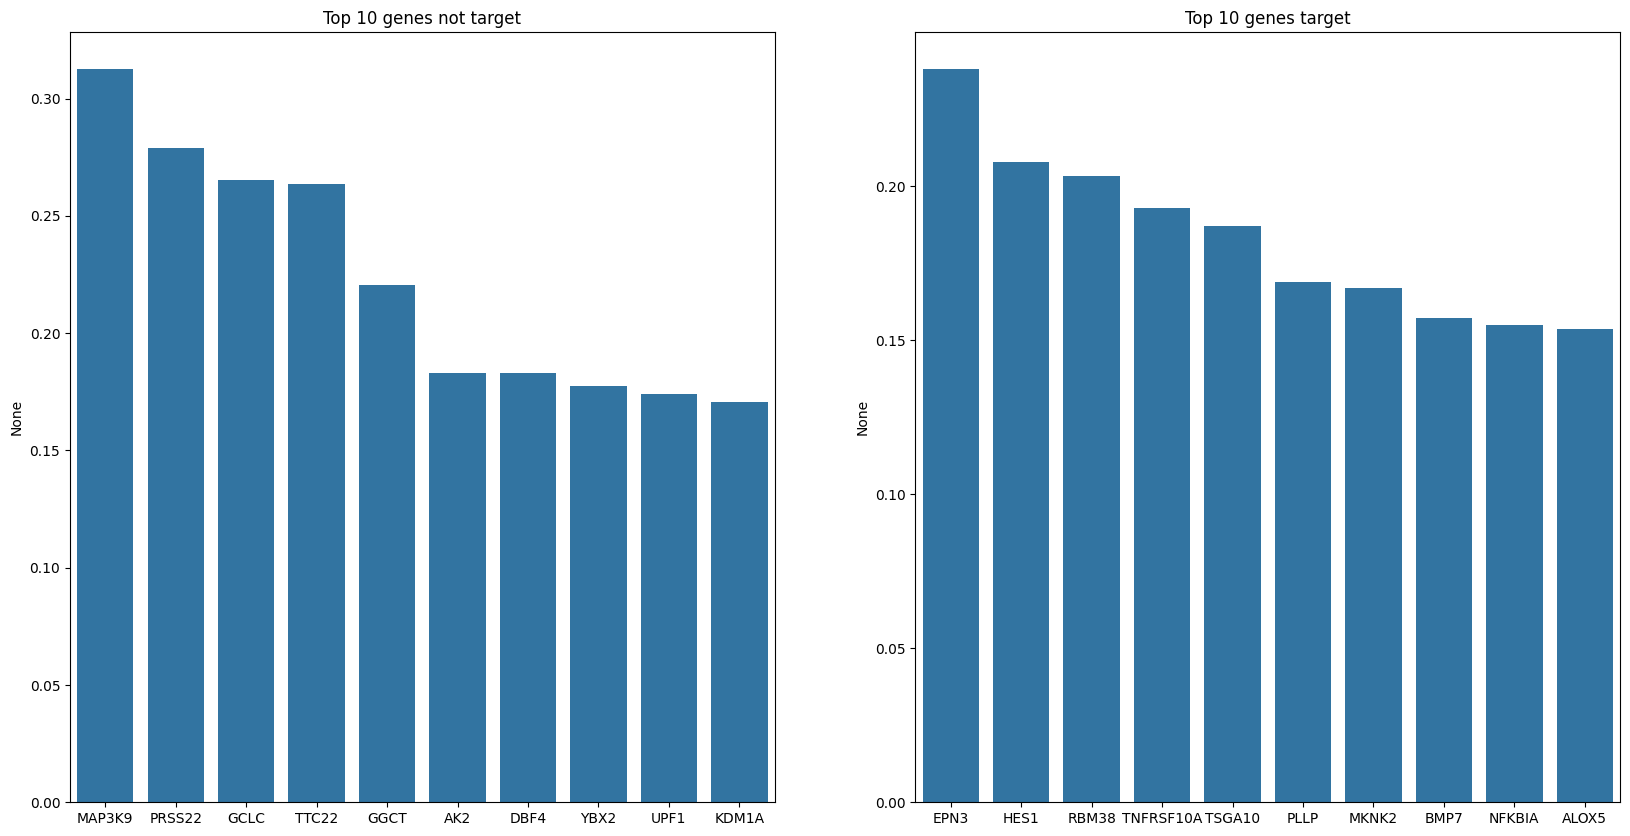

In [9]:
mod_sub_corr = mod_sub.corrwith(mutated, method='pearson')
top_10_genes_nt = mod_sub_corr.sort_values(ascending=False).head(10).index.tolist()
print("Top 10 genes not target:", top_10_genes_nt)

mod_sub_filter_corr = mod_sub_filter.corrwith(mutated, method='pearson')
top_10_genes_t = mod_sub_filter_corr.sort_values(ascending=False).head(10).index.tolist()
print("Top 10 genes target:", top_10_genes_t)


plt.figure(figsize=(20,10))
plt.subplot(1, 2, 1)
sns.barplot(x=top_10_genes_nt, y=mod_sub_corr[top_10_genes_nt])
plt.title('Top 10 genes not target')
plt.subplot(1, 2, 2)
sns.barplot(x=top_10_genes_t, y=mod_sub_filter_corr[top_10_genes_t])
plt.title('Top 10 genes target')
plt.show()

In [10]:
print(f"mean of target data",abs(mod_sub_filter_corr.mean()))
print(f"mean of non target data",abs(mod_sub_corr.mean()))


mean of target data 0.03878464790490457
mean of non target data 0.038511195805390745


### The mean of target data correlation is higher, furthermore the general correlation between target and non target genes is comparable, therefore we can filter the dataset columns wit the target genes

In [11]:
mod_data = merged_mod[merged_mod.columns[merged_mod.columns.isin(target_genes)]]

### Train-Test Split

In [12]:
# Split data into train and test sets
X = mod_data
y = mutated
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Model Training and Evaluation

### First model: Logistic Regression

Classification Report:
              precision    recall  f1-score   support

           0       0.76      0.73      0.75       128
           1       0.84      0.86      0.85       213

    accuracy                           0.81       341
   macro avg       0.80      0.80      0.80       341
weighted avg       0.81      0.81      0.81       341



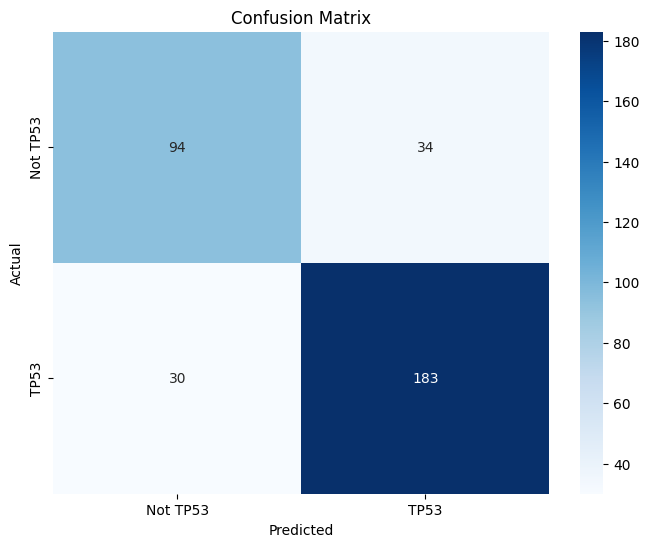

In [13]:
#fit the model
lg_model = LogisticRegression(max_iter=10000,random_state=42)
lg_model.fit(X_train, y_train)
#predict the test set
y_pred = lg_model.predict(X_test)
#predict the probabilities
y_pred_proba = lg_model.predict_proba(X_test)[:, 1]
#calculate the confusion matrix
cm = confusion_matrix(y_test, y_pred)
#calculate the classification report
report = classification_report(y_test, y_pred)
print("Classification Report:")
print(report)
# Plot the confusion matrix using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Not TP53', 'TP53'], yticklabels=['Not TP53', 'TP53'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

### Second Model: Random Forest

Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.75      0.81       128
           1       0.86      0.94      0.90       213

    accuracy                           0.87       341
   macro avg       0.88      0.85      0.86       341
weighted avg       0.87      0.87      0.87       341



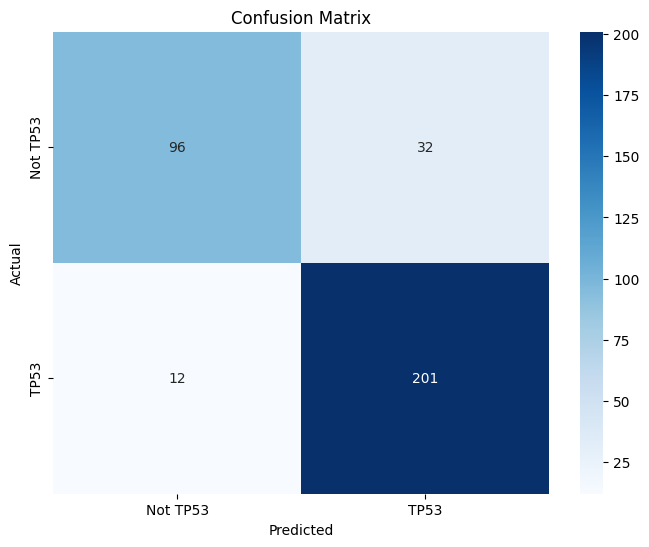

In [14]:
rf_model = RandomForestClassifier(n_estimators=200, min_samples_split=2, max_depth=10, class_weight='balanced',random_state=42)
rf_model.fit(X_train, y_train)
#predict the test set
y_pred = rf_model.predict(X_test)
#predict the probabilities
y_pred_proba = rf_model.predict_proba(X_test)[:, 1]
#calculate the confusion matrix
cm = confusion_matrix(y_test, y_pred)
#calculate the classification report
report = classification_report(y_test, y_pred)
print("Classification Report:")
print(report)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Not TP53', 'TP53'], yticklabels=['Not TP53', 'TP53'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

### Third model: XGboost

              precision    recall  f1-score   support

           0       0.90      0.81      0.85       128
           1       0.89      0.94      0.92       213

    accuracy                           0.89       341
   macro avg       0.89      0.88      0.89       341
weighted avg       0.89      0.89      0.89       341



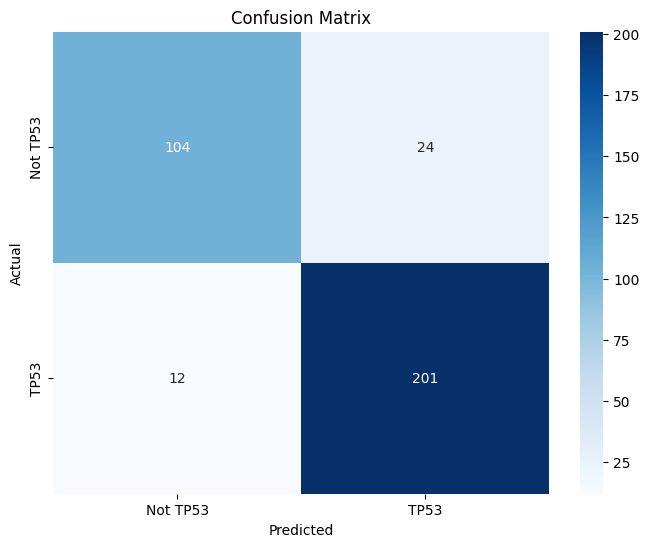

In [15]:
xgb_model = XGBClassifier(n_estimators=200, max_depth=10, learning_rate=0.1, scale_pos_weight=1,random_state=42)
xgb_model.fit(X_train, y_train)
#predict the test set
y_pred = xgb_model.predict(X_test)
#predict the probabilities
y_pred_proba = xgb_model.predict_proba(X_test)[:, 1]
#calculate the confusion matrix
cm = confusion_matrix(y_test, y_pred)
#calculate the classification report
report = classification_report(y_test, y_pred)
print(report)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Not TP53', 'TP53'], yticklabels=['Not TP53', 'TP53'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

### Feature Importance Analysis

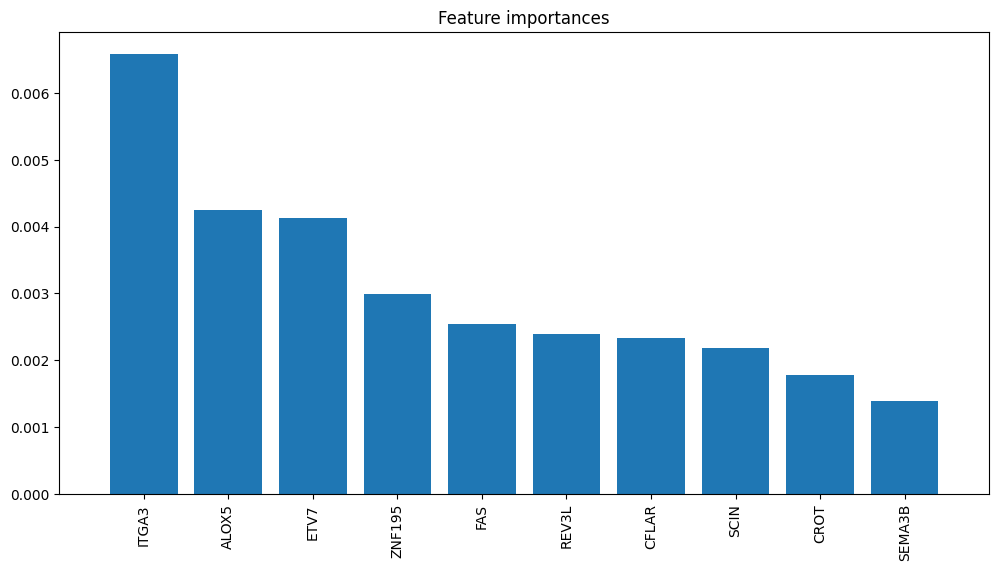

In [16]:
#feature importance
importances = (xgb_model.feature_importances_)[:10]
indices = np.argsort(importances)[::-1]
# Print the feature ranking
plt.figure(figsize=(12, 6))
plt.title("Feature importances")
plt.bar(range(len(importances)), importances[indices], align="center")
plt.xticks(range(len(importances)), X_train.columns[indices], rotation=90)
plt.xlim([-1, len(importances)])
plt.show()

- ITGA3 (highest importance):
   Integrin Subunit Alpha 3 - A cell surface adhesion receptor that mediates cell-matrix interactions. Its high importance suggests TP53 mutations may significantly affect cell adhesion pathways, which aligns with cancer's tendency to metastasize when TP53 is mutated.
   
- ALOX5: 
   ALOX5 (Arachidonate 5-Lipoxygenase) - An enzyme involved in inflammatory responses and leukotrienes synthesis. This connection suggests TP53 mutations may alter inflammatory pathways in cancer cells.

- ETV7: 
   ETS Variant Transcription Factor 7 - A transcription factor that can act as a cancer-promoting gene. Its importance suggests potential regulatory relationships between TP53 and this transcription factor.

- ZNF195: 
   Zinc Finger Protein 195 - A transcription regulator. Its presence suggests altered transcriptional regulation networks in TP53-mutated cancers.

- FAS: 
   Fas Cell Surface Death Receptor - A critical regulator of programmed cell death (apoptosis). TP53 directly regulates FAS, so their relationship in our model makes biological sense.

- REV3L: 
   DNA Polymerase Zeta Catalytic Subunit - Involved in DNA repair mechanisms. TP53 mutations often disrupt DNA repair pathways, explaining this connection.

- CFLАР: 
   CASP8 And FADD Like Apoptosis Regulator - Regulates apoptosis, particularly in the extrinsic death receptor pathway. This reinforces the apoptotic dysregulation in TP53-mutated cancers.

- SCIN: 
   Scinderin - An actin-severing protein involved in cytoskeletal remodeling. This suggests potential changes in cellular architecture associated with TP53 mutations.

- CROT: 
   Carnitine O-Octanoyltransferase - Involved in lipid metabolism. This hints at metabolic reprogramming in TP53-mutated cancers.

- SEMA3B: 
   Semaphorin 3B - A potential tumor suppressor that can induce apoptosis. Its presence suggests altered tumor suppression networks when TP53 is mutated.

Biological interpretation of this plot:

- This model highlights genes involved in multiple cancer-related processes: cell adhesion, apoptosis, DNA repair, and        transcriptional regulation.

- Several of these genes (FAS, REV3L, CFLAR) are known to interact with TP53 pathways
 The importance of ITGA3 being significantly higher than others suggests cell adhesion changes may be a dominant feature of TP53-mutated cancer cell lines in our dataset.

The diverse functions of these genes reflect how TP53 mutations have wide-ranging effects across multiple cellular systems.